# Build predictive model of testosterone level 

In [77]:
# load libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt # For plotting
import seaborn as sns # For plotting
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler # For scaling features
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import roc_auc_score, roc_curve
import xgboost as xgb # For XGBoost model
import shap # For SHAP values

## Load data

In [78]:
# load muscle data
data = pd.read_csv('../result/muscle/testosterone_vst_all_genes.csv', index_col=1)
data.index.name = None
data = data.drop(columns=['Unnamed: 0'])
data = data.T
data.head()

,TSPAN6,DPM1,SCYL3,FIRRM,FGR,CFH,FUCA2,GCLC,NFYA,NIPAL3,...,TSC22D1-AS1,MYO19,GGNBP2,DHRS11,ACACA,C11orf98,MRPL45,PWAR5,LOC102724023,UCKL1-AS1
51,7.237980,8.982439,8.372810,6.996850,6.337944,8.717237,7.524025,8.350693,8.205073,8.080710,...,8.617708,8.482478,9.411559,7.882486,8.678971,7.619431,9.313512,9.487425,7.308583,6.540656
47,7.294497,9.185095,8.212617,7.027088,6.366138,8.093468,7.453548,8.453398,8.232324,8.136095,...,8.752739,8.038242,9.602383,8.251753,8.580889,7.602619,9.412092,9.702731,5.972536,6.709533
48,7.588868,8.794648,8.239873,6.958211,6.312089,9.311900,7.805413,8.474918,8.523047,8.433504,...,8.037135,8.225297,9.405879,7.751062,8.661823,7.604475,9.449623,9.223368,7.665095,6.636014
9,7.372851,8.720572,8.264777,6.942539,7.646977,8.723982,7.453659,8.236102,8.561747,8.306704,...,8.382598,7.964631,9.652853,7.712629,8.491212,7.553950,9.475581,9.838920,7.802029,6.844666
15,7.162529,9.063719,8.022719,6.954096,6.290366,8.051127,7.450770,8.100815,8.067892,8.498412,...,7.890117,8.143516,9.249969,7.825231,8.379595,7.569224,9.495483,9.708460,7.616825,6.440679


In [79]:
data.shape

(37, 11704)

In [80]:
data.columns = data.columns.astype(str)

In [81]:
# load muscle metadata
metadata = pd.read_csv('../result/muscle/testosterone_clinical_data.csv', index_col=0)
metadata.head()

,sex,age,E2..pg.ml.,testosterone,group
51,M,O,22,85,low
47,M,O,16,144,low
48,M,O,21,275,low
9,M,O,33,309,low
15,M,Y,27,324,low


In [82]:
metadata.shape

(37, 5)

In [83]:
# mapping groups to nunmeric values
metadata['category'] = metadata['group'].map({'low': 0, 'high': 1})
metadata.head()

,sex,age,E2..pg.ml.,testosterone,group,category
51,M,O,22,85,low,0
47,M,O,16,144,low,0
48,M,O,21,275,low,0
9,M,O,33,309,low,0
15,M,Y,27,324,low,0


In [84]:
# check whether the samples in the metadata match the samples in the data
data.index == metadata.index

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

## Exploratory data analysis

In [85]:
# Scale the data for PCA and t-SNE
data_scaled = StandardScaler().fit_transform(data)

In [86]:
# Prepare the first 2 PCA components and plot
pca_2c = PCA(n_components = 2)
pca_2c_features = pca_2c.fit_transform(data_scaled)

pca_2c_df = pd.DataFrame(
    data = pca_2c_features, 
    columns = ['PC1', 'PC2'])

target = list(metadata['group'])
sample_ids = [x+'-'+str(y) for x,y in zip(list(metadata.index),metadata['testosterone'])]
pca_2c_df['sample_id'] = sample_ids

pca_2c_df['target'] = target

expl_var = round(sum(pca_2c.explained_variance_ratio_) * 100, 2)

pca1_expl_var = round(pca_2c.explained_variance_ratio_[0] * 100, 2)
pca2_expl_var = round(pca_2c.explained_variance_ratio_[1] * 100, 2)

x_title = "PC1 (" + str(pca1_expl_var) + "%)"
y_title = "PC2 (" + str(pca2_expl_var) + "%)"

sub_title = "(Explained variance for PC1 and PC2 : " + str(expl_var) + "%)"
title = "PCA Plot \n" + sub_title

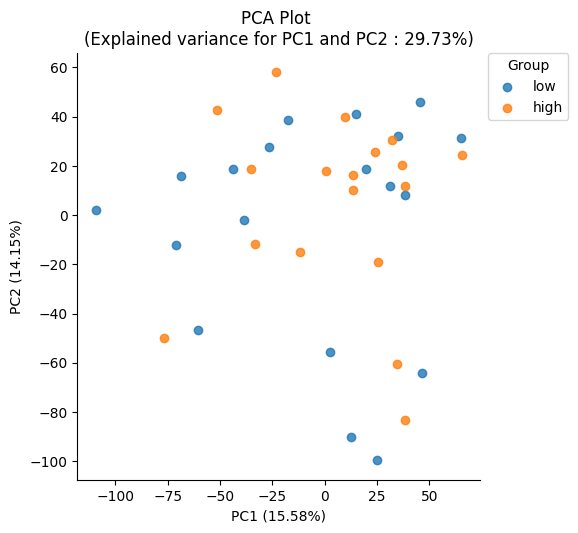

In [87]:
# Plot the first 2 PCA components

sns.lmplot(
    x = 'PC1', 
    y = 'PC2',
    data = pca_2c_df,
    hue = 'target',
    fit_reg = False,
    legend = False
)
plt.title(title)
plt.legend(bbox_to_anchor=(1.02, 1), loc = 'upper left', borderaxespad = 0, title = 'Group')
plt.xlabel(x_title)
plt.ylabel(y_title)
plt.show()

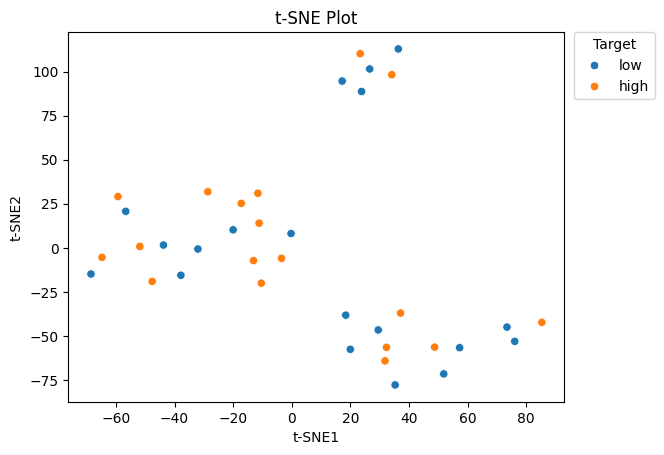

In [88]:
# t-SNE plot
tsne = TSNE(random_state=0, perplexity=5)  # Set perplexity to a value less than n_samples
tsne_results = tsne.fit_transform(data_scaled)
tsne_results = pd.DataFrame(tsne_results, columns=['t-SNE1', 't-SNE2'])
tsne_results['target'] = target
tsne_results['sample_id'] = sample_ids

sns.scatterplot(data=tsne_results, 
                x="t-SNE1", 
                y="t-SNE2",
                hue='target',
                legend=True
               )
plt.title('t-SNE Plot')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, title='Target')
plt.show()

## Overlapping genes between muscle and PBMC dataset and creating new data base on overlapping genes

In [89]:
muscle_genes = data.columns.tolist()
len(muscle_genes)

11704

In [90]:
# load PBMC data
pbmc_data = pd.read_csv('../result/pbmc/testosterone_vst_all_genes.csv', index_col=1)
pbmc_data.index.name = None
pbmc_data = pbmc_data.drop(columns=['Unnamed: 0'])
pbmc_data = pbmc_data.T
pbmc_data.head()


,TSPAN6,DPM1,SCYL3,FIRRM,FGR,CFH,FUCA2,GCLC,NFYA,STPG1,...,CASP12,HAT1,SLC25A12,LOC124905558,LOC102724250,MROH8,GPATCH4,LOC124906262,CCL3L3,LOC131768270
RS04,6.869759,9.847670,8.882696,7.438358,12.922613,7.238995,10.050459,9.610406,8.945675,7.363101,...,6.340911,10.390623,8.831688,6.978709,6.680037,6.997584,8.947282,7.380484,6.815199,9.996214
RS26,6.573789,9.419026,9.047389,7.349889,13.599043,7.481852,10.125458,10.114983,10.127692,7.309280,...,6.521277,9.849578,9.208052,6.801086,6.969361,6.067366,8.977994,8.044510,6.552695,10.224503
RS37,6.676587,9.177139,9.074602,7.898989,13.611131,7.411413,10.003618,10.128117,10.044768,7.466954,...,6.950381,9.684209,8.944637,7.892600,6.970406,6.575673,8.768855,9.370031,6.647410,10.002117
RS06,6.923362,9.142882,9.009747,7.227477,13.714925,7.232627,9.878816,9.866949,10.183477,7.487932,...,6.554050,9.319682,8.770374,7.360490,8.058101,6.442379,9.464115,7.765501,6.641093,10.571591
RS07,6.905475,9.315137,9.126098,7.619496,13.206565,8.041342,9.779148,9.747184,10.132431,7.506973,...,6.640528,9.839457,9.177754,7.180496,7.637600,6.437471,8.933741,8.155389,6.624863,10.444303


In [91]:
pbmc_data.shape

(10, 13354)

In [92]:
pbmc_genes = pbmc_data.columns.tolist()
len(pbmc_genes)

13354

In [93]:
overlapping_genes = list(set(muscle_genes).intersection(pbmc_genes))
len(overlapping_genes)

10180

In [94]:
muscle_data_filtered = data.loc[:, overlapping_genes]
pbmc_data_filtered = pbmc_data.loc[:, overlapping_genes]
muscle_data_filtered.shape, pbmc_data_filtered.shape

((37, 10180), (10, 10180))

## Train Test Split

In [95]:
a = int(input("Press Enter to continue..."))

In [96]:
# Assign response, and split data for train and test
y =  metadata["category"]
X_train, X_test, y_train, y_test = train_test_split(muscle_data_filtered,
                                                    y,
                                                    test_size = 0.3, 
                                                    random_state = a)   
print("X_train shape", X_train.shape)
print("X_test shape", X_test.shape)

X_train shape (25, 10180)
X_test shape (12, 10180)


## XGBoost

In [97]:
# Initiate and train the model
dtrain = xgb.DMatrix(X_train, label=y_train.values)
dtest = xgb.DMatrix(X_test, label=y_test.values)
param = {'max_depth': 10,                       #  this has to be optimised for your model, range between 0->
         'eta': 0.5,                           #  this has to be optimised for your model, range between 0-1
         'objective': 'binary:logistic',       #  this depends on the nature of your model
        }

param['eval_metric'] = 'auc'                   #  this depends on the objective 
num_round = 100                                # number of rounds for boosting
evallist = [(dtest, 'eval'),(dtrain, 'train')] # eval test
progress = {}
model = xgb.train(param, dtrain, num_round, 
                        
                     evals=evallist, evals_result = progress, 
                     verbose_eval=5, 
                     early_stopping_rounds=20) 

# classes in y_test
print(" ")
print("bincount y_test:", np.bincount(y_test))

[0]	eval-auc:0.47143	train-auc:0.93269
[5]	eval-auc:0.42857	train-auc:1.00000
[10]	eval-auc:0.51429	train-auc:1.00000
[15]	eval-auc:0.51429	train-auc:1.00000
[20]	eval-auc:0.51429	train-auc:1.00000
 
bincount y_test: [7 5]


In [98]:
# Generate test predictions and assign to the nearest classification
preds = model.predict(dtest)
prediction =[]
for i in preds:
    if i >=0.5:
        prediction.append(1)
    else:
        prediction.append(0)
print("bincount prediction:", np.bincount(prediction))

bincount prediction: [5 7]


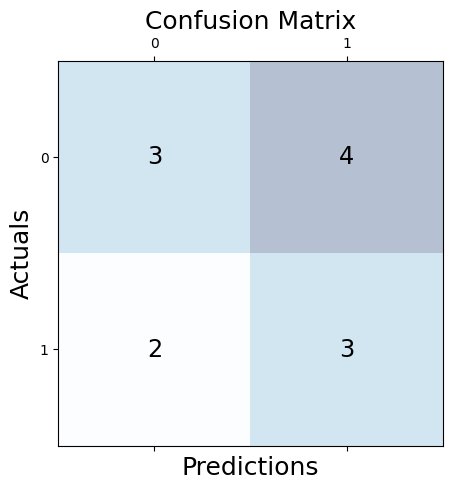

In [99]:
conf_matrix = confusion_matrix(y_true = y_test, y_pred = prediction)

# Print the confusion matrix using Matplotlib
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [100]:
# Scores

print('Accuracy: %.3f' % accuracy_score(y_test, prediction))
print('F1 Score (Weighted): %.3f' % f1_score(y_test, prediction, average='weighted'))
print('Precision (Weighted): %.3f' % precision_score(y_test, prediction, average='weighted'))
print('Recall (Weighted): %.3f' % recall_score(y_test, prediction, average='weighted'))

Accuracy: 0.500
F1 Score (Weighted): 0.500
Precision (Weighted): 0.529
Recall (Weighted): 0.500


### ROC curve

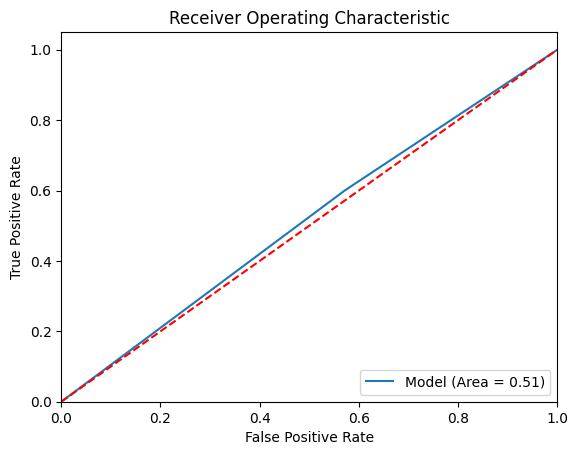

In [101]:
y_true = np.array(y_test.values)
pred_array = np.array(prediction)
muscle_roc = roc_auc_score(y_true, pred_array)

muscle_fpr, muscle_tpr, muscle_thresholds = roc_curve(y_true, pred_array) 
plt.figure()
plt.plot(muscle_fpr, muscle_tpr, label='Model (Area = %0.2f)' % muscle_roc) 
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

### SHAP summary plot


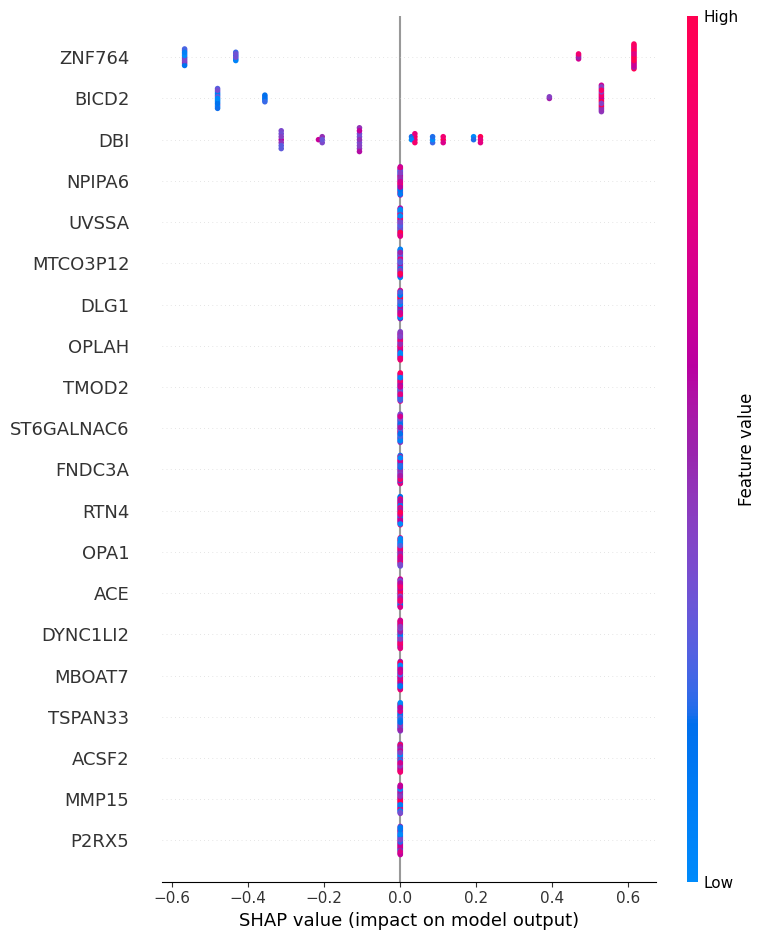

In [102]:
shap.initjs()

# Apply the generated model to the whole dataset and calculate the shap values
shap_values = shap.TreeExplainer(model).shap_values(muscle_data_filtered.values)  
explainer = shap.TreeExplainer(model, muscle_data_filtered.values)
expected_value = explainer.expected_value

features = muscle_data_filtered.columns

# Convert data DF to array
data_ = muscle_data_filtered.to_numpy()

# Run predictions for the whole dataset
d_data = xgb.DMatrix(muscle_data_filtered, label=y.values)

preds_data = model.predict(d_data)
prediction_data =[]
for i in preds_data:
    if i >=0.5:
        prediction_data.append(1)
    else:
        prediction_data.append(0)

# Print the shap summary plot
shap.summary_plot(shap_values, muscle_data_filtered, feature_names=muscle_data_filtered.columns) 

### SHAP force plot

In [103]:
# A function that displays the actual value, the predicted value and testosterone level
# that is added to the force plot 
# Adapted from Max Steele def shap_force 
# https://medium.com/mlearning-ai/shap-force-plots-for-classification-d30be430e195

def shap_accuracy(prediction_list, index, y_values, DA_values):
    pred = prediction_list[index]
    
    true_label = y_values[index]
    
    DA = DA_values[index]
    
    ## Assess accuracy of prediction
    if true_label == pred:
        accurate = 'Correct'
    else:
        accurate = 'Incorrect'
        
    ## Print output that checks model's prediction against true label
    print('***'*12)
    # print ground truth label for row at index
    print(f'Ground Truth Label: {true_label}')
    # Print model prediction for row at index
    print(f'Model Prediction:  {pred} -- {accurate}')
    # print disease activity score
    print(f'Score: {DA}')
    print('***'*12)
    print()

In [104]:
# Rank the testosterone level, and get the positions of the 5 samples
# with the highest testosterone level and the 5 samples with the lowest

DAranking = metadata[['testosterone']]
DAranking.insert(loc=0, column="rowPosition", value=np.arange(len(DAranking))) # column with row position
DAranking = DAranking.sort_values(by = 'testosterone', ascending = False)         # sort testosterone level in descending order
DAranking.insert(loc=0, column="DAorder", value=np.arange(len(DAranking)))     # column with testosterone level order position
DAranking = DAranking.drop(columns="testosterone")

# Get row positions of top 5
positionlist = DAranking["rowPosition"].tolist()
TopDA = positionlist[:5]
print("TOP 5 DA rows", TopDA)

# Get row positions of bottom 5
positionlist.reverse()
BotDA = positionlist[:5]
print("BOTTOM 5 DA rows", BotDA)

# testosterone level into a series        
DA = metadata[['testosterone']]
DA = DA.to_numpy()

TOP 5 DA rows [36, 35, 34, 33, 32]
BOTTOM 5 DA rows [0, 1, 2, 3, 4]


In [105]:
print(prediction_data)
print(y.values.tolist())

[0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


************************************
Ground Truth Label: 1
Model Prediction:  1 -- Correct
Score: [938]
************************************



C:\Users\ngduy\AppData\Local\Temp\ipykernel_23220\1801691292.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  true_label = y_values[index]


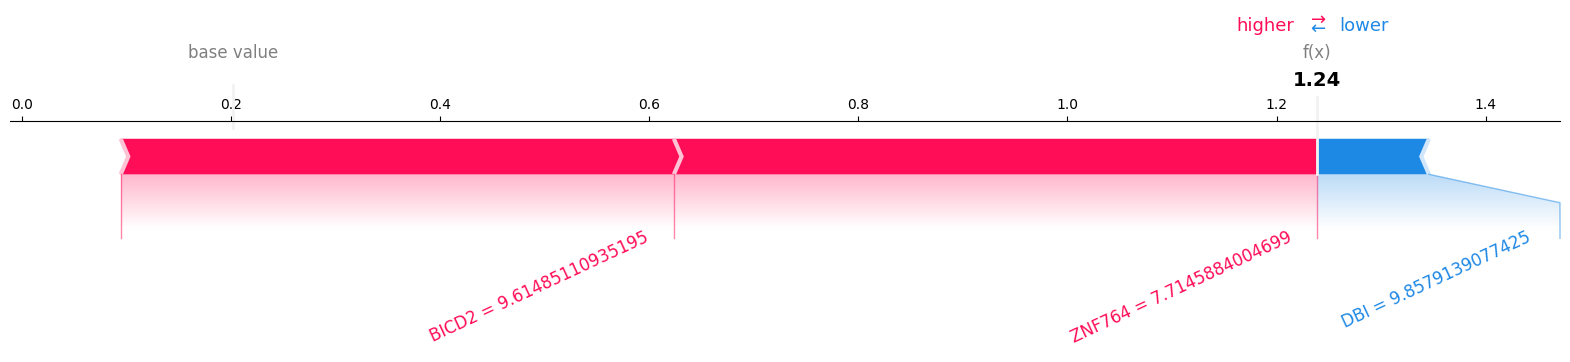

************************************
Ground Truth Label: 1
Model Prediction:  1 -- Correct
Score: [701]
************************************



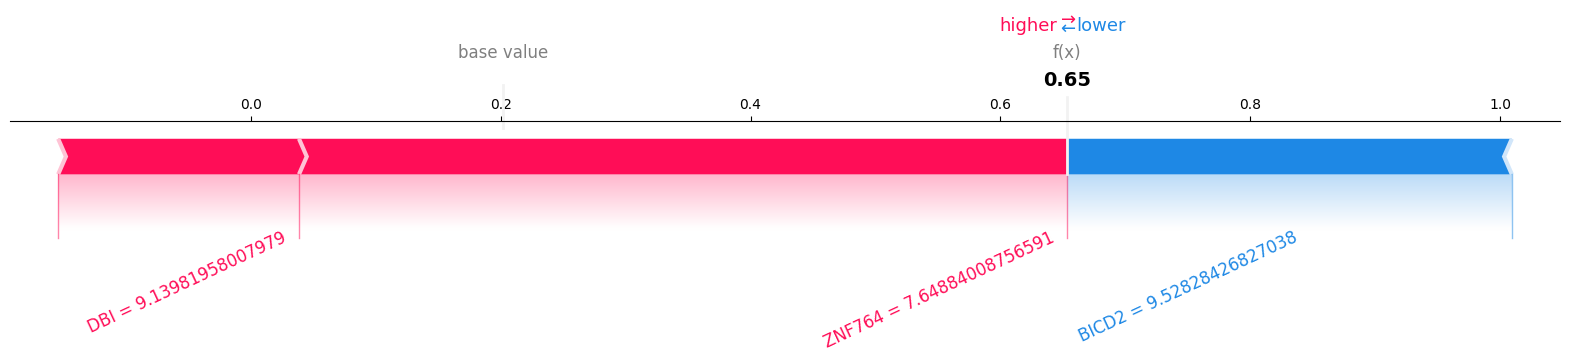

************************************
Ground Truth Label: 1
Model Prediction:  1 -- Correct
Score: [663]
************************************



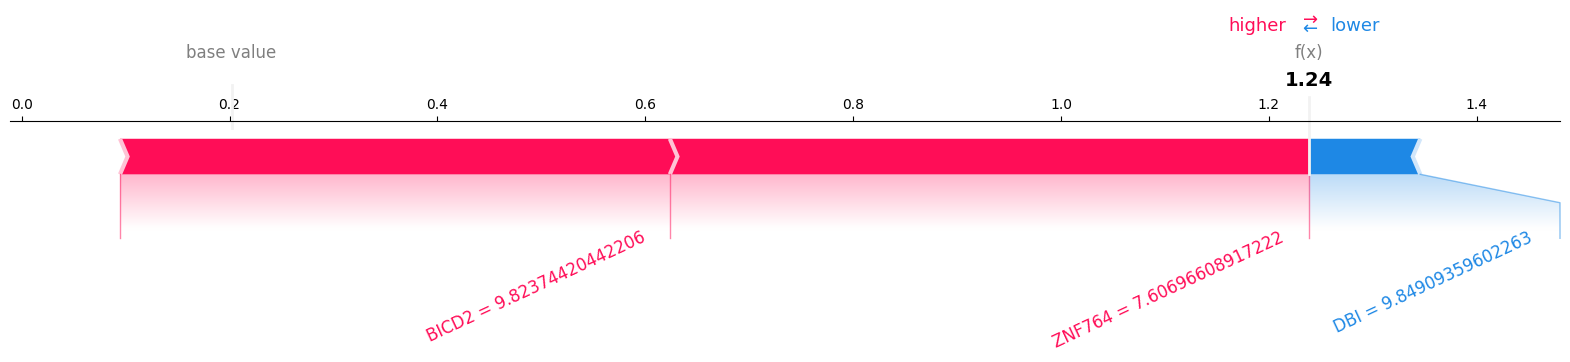

************************************
Ground Truth Label: 1
Model Prediction:  1 -- Correct
Score: [629]
************************************



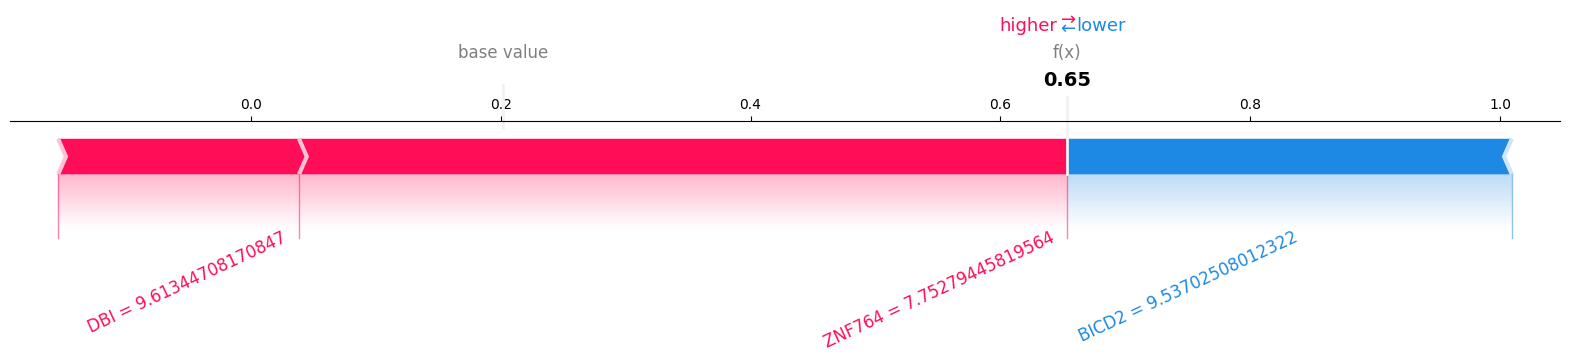

************************************
Ground Truth Label: 1
Model Prediction:  1 -- Correct
Score: [620]
************************************



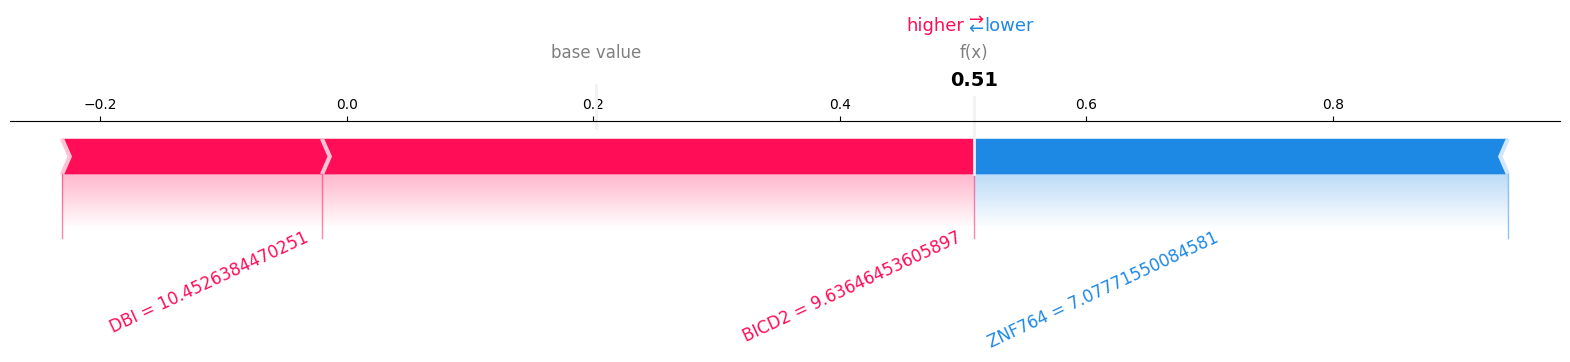

In [106]:
# Force plots for top 5 testosterone level
for i in TopDA:
    shap_accuracy(prediction_data, i, y, DA)
    shap.force_plot(expected_value, shap_values[i], data_[i], feature_names = features,
                matplotlib = True, plot_cmap="PkYg", text_rotation = 25)

************************************
Ground Truth Label: 0
Model Prediction:  0 -- Correct
Score: [85]
************************************



C:\Users\ngduy\AppData\Local\Temp\ipykernel_23220\1801691292.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  true_label = y_values[index]


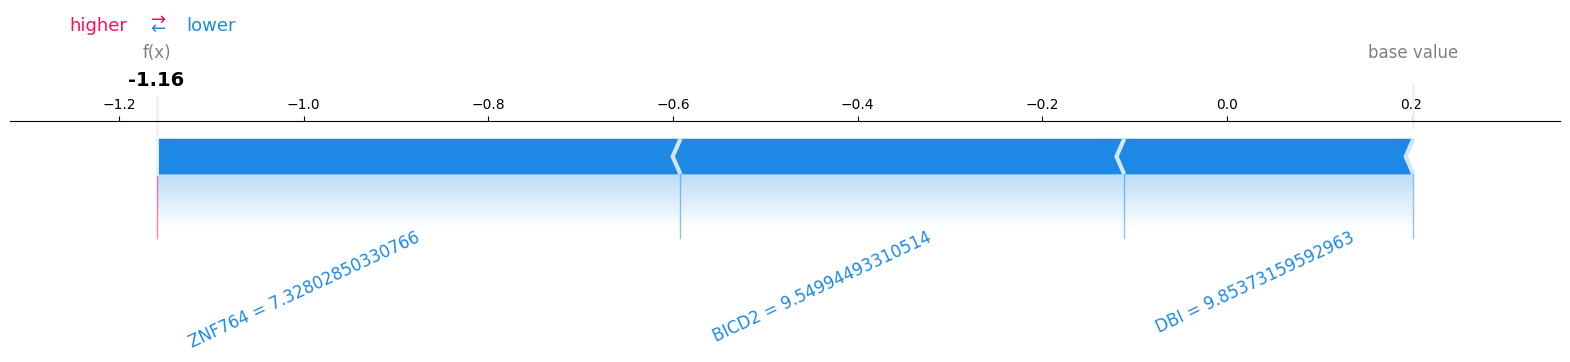

************************************
Ground Truth Label: 0
Model Prediction:  0 -- Correct
Score: [144]
************************************



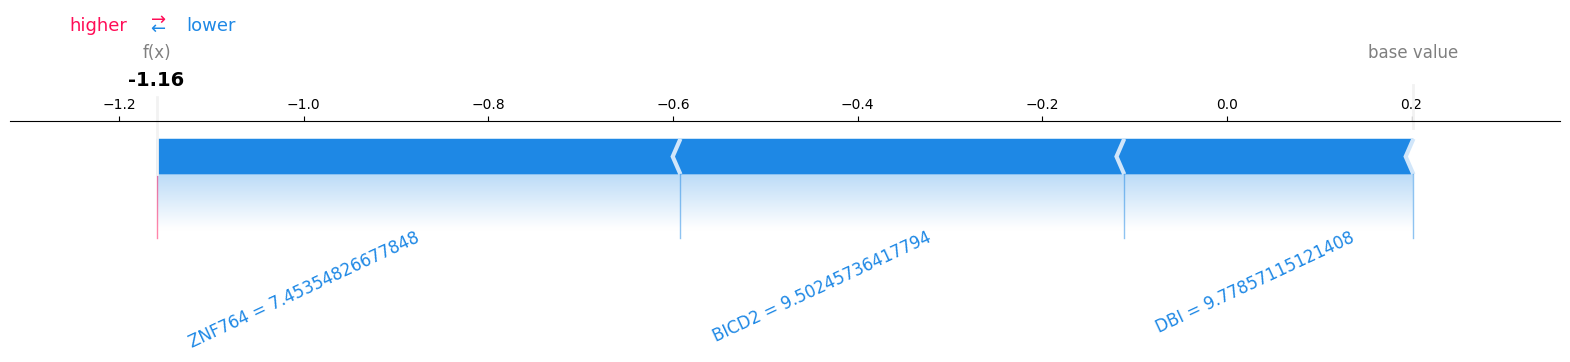

************************************
Ground Truth Label: 0
Model Prediction:  0 -- Correct
Score: [275]
************************************



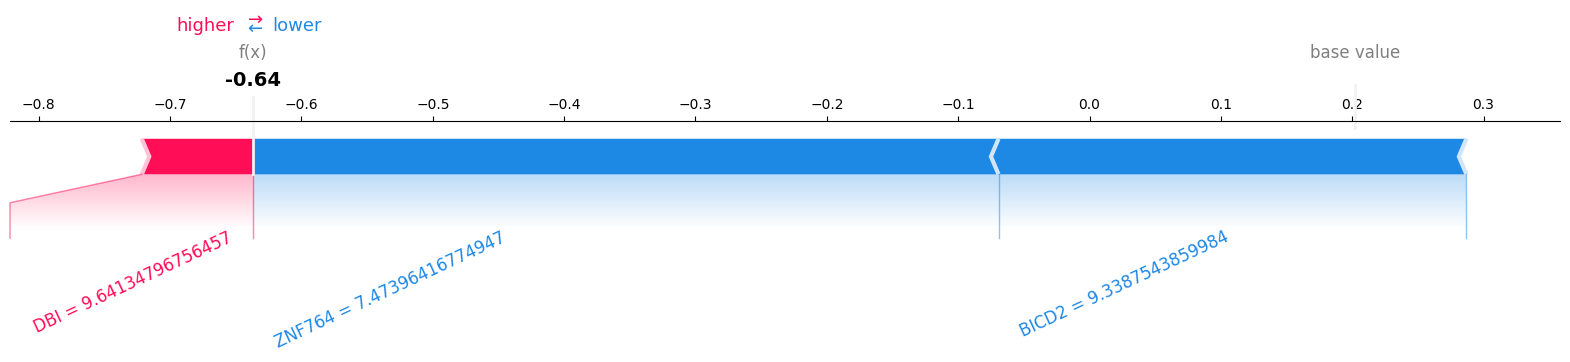

************************************
Ground Truth Label: 0
Model Prediction:  0 -- Correct
Score: [309]
************************************



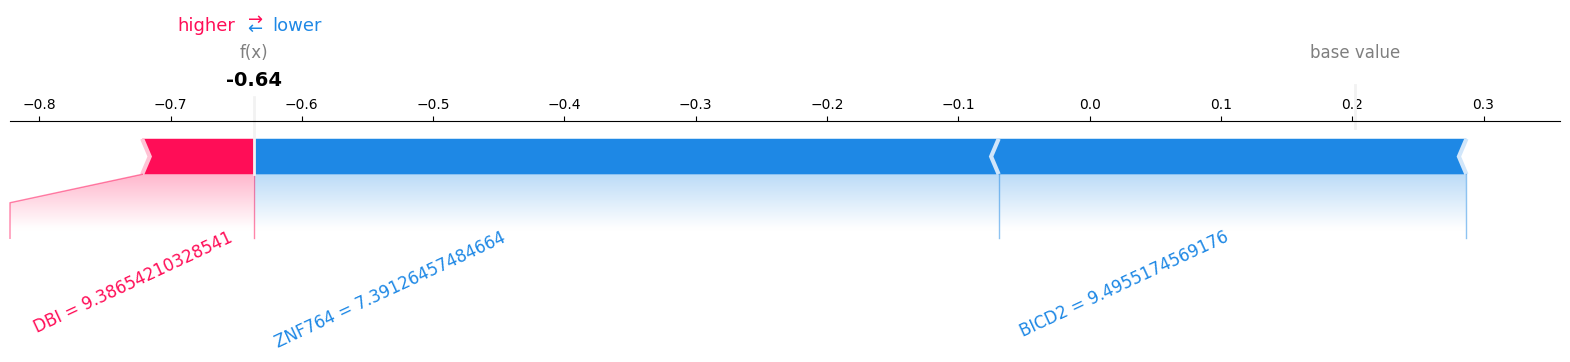

************************************
Ground Truth Label: 0
Model Prediction:  1 -- Incorrect
Score: [324]
************************************



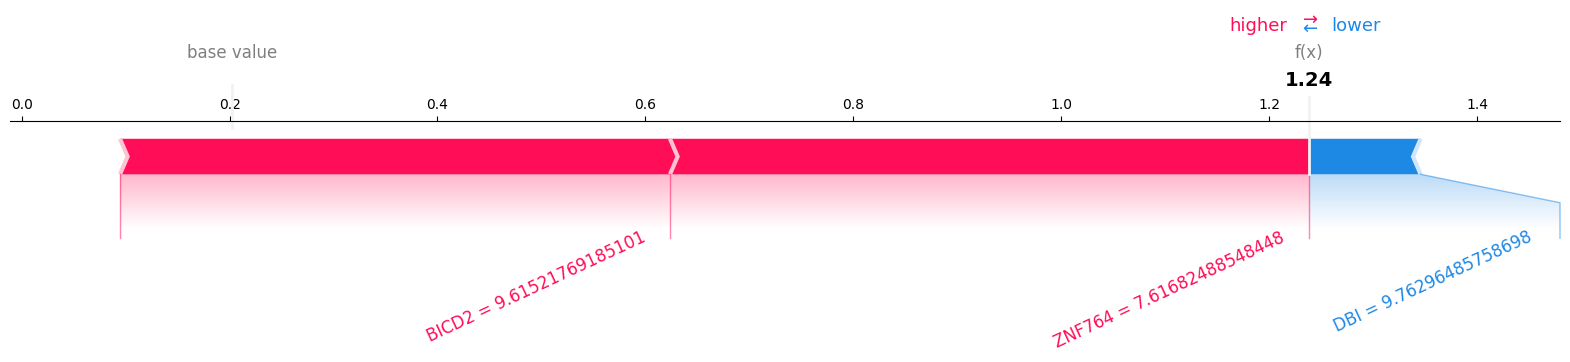

In [107]:
# Force plots for bottom 5 testosterone level
for i in BotDA:
    shap_accuracy(prediction_data, i, y, DA)
    shap.force_plot(expected_value, shap_values[i], data_[i], feature_names = features,
                matplotlib = True, plot_cmap="PkYg", text_rotation = 25)

## PBMC prediction

In [108]:
# load PBMC metadata
pbmc_metadata = pd.read_csv('../result/pbmc/testosterone_clinical_data.csv', index_col=0)
pbmc_metadata.head()

,sex,age,testosterone,BMI,group
RS04,Male,30,297.0726,24.0,low
RS26,Male,42,328.7988,23.0,low
RS37,Male,35,331.6830,30.0,low
RS06,Male,39,380.7144,26.0,low
RS07,Male,32,418.2090,23.0,low


In [109]:
# mapping groups to numeric values
pbmc_metadata['category'] = pbmc_metadata['group'].map({'low': 0, 'high': 1})
pbmc_metadata.head()

,sex,age,testosterone,BMI,group,category
RS04,Male,30,297.0726,24.0,low,0
RS26,Male,42,328.7988,23.0,low,0
RS37,Male,35,331.6830,30.0,low,0
RS06,Male,39,380.7144,26.0,low,0
RS07,Male,32,418.2090,23.0,low,0


In [110]:
# check whether the samples in the metadata match the samples in the data
pbmc_data_filtered.index == pbmc_metadata.index

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

In [111]:
muscle_data_filtered.head()

,EIF3FP3,DBI,IRAK3,P2RX5,MMP15,ACSF2,TSPAN33,MBOAT7,DYNC1LI2,ACE,...,SLCO3A1,NOL10,CD34,HLA-F,SKIC2,CCDC186,KLF15,OPLAH,CCT2,YTHDC1
51,8.918417,9.853732,7.337637,8.286820,7.937850,8.747790,8.494595,7.750576,10.425532,8.671901,...,7.931809,8.466157,10.346494,7.925742,8.599170,9.392480,9.432463,9.438675,9.958119,10.166622
47,9.019225,9.778571,7.064050,8.294495,7.513602,9.097985,8.453398,7.671155,10.194660,7.986545,...,7.932797,8.440827,10.208114,7.578946,8.577075,9.236354,8.818589,9.466177,10.149726,10.270066
48,8.748393,9.641348,7.308998,8.268570,7.950364,8.765087,8.412327,7.737119,10.469232,8.741660,...,8.025881,8.474918,10.511967,8.102772,8.636598,9.537159,8.913067,9.220962,10.554421,9.914985
9,8.750964,9.386542,7.115680,8.610568,7.553950,8.847790,8.595726,8.274204,10.416253,8.201876,...,7.828367,8.329460,9.996651,7.904400,8.844667,9.336538,8.093768,8.857118,10.100320,10.224679
15,9.257126,9.762965,6.825646,8.106226,7.511371,8.905290,8.626604,7.228019,10.288895,8.477923,...,8.028448,8.674057,9.469055,7.544749,8.702483,9.347044,9.285401,9.429530,10.025001,9.886212


In [112]:
pbmc_data_filtered.head()

,EIF3FP3,DBI,IRAK3,P2RX5,MMP15,ACSF2,TSPAN33,MBOAT7,DYNC1LI2,ACE,...,SLCO3A1,NOL10,CD34,HLA-F,SKIC2,CCDC186,KLF15,OPLAH,CCT2,YTHDC1
RS04,6.450620,10.656571,10.496354,9.737204,6.969266,8.424481,10.733725,9.893860,9.566307,7.284210,...,10.571377,9.038873,7.295520,8.907539,9.285085,8.751078,8.527854,7.920207,11.314161,10.036355
RS26,6.547046,10.380704,10.618665,10.716903,6.953324,8.555891,10.604166,10.672852,9.644680,7.056768,...,10.820444,9.200149,6.901147,8.527566,7.312193,9.870141,6.947066,7.435697,10.711247,10.390458
RS37,6.692411,9.748952,11.692466,10.474470,6.630890,8.805634,9.227880,10.069320,10.744807,8.074151,...,10.761186,9.127807,7.140548,8.231904,9.935297,10.338687,6.738465,7.851321,10.633021,10.455887
RS06,6.652837,9.607206,10.570503,10.385262,6.787422,8.381924,9.944550,10.756884,9.749206,7.699627,...,11.237015,9.292959,7.220990,8.300036,7.862272,9.521255,6.328781,7.676412,10.256331,10.520541
RS07,7.127681,10.067719,10.932661,9.438295,6.834081,8.449403,9.878710,10.755113,9.778132,7.693999,...,10.852915,9.182659,7.040881,8.435482,7.584524,10.061208,6.694926,7.564547,10.807171,10.477029


In [113]:
pbmc_predict= model.predict(xgb.DMatrix(pbmc_data_filtered,label=pbmc_metadata['category'].to_numpy()))

In [114]:
pbmc_prediction_result = []
for i in pbmc_predict:
    if i >=0.5:
        pbmc_prediction_result.append(1)
    else:
        pbmc_prediction_result.append(0)

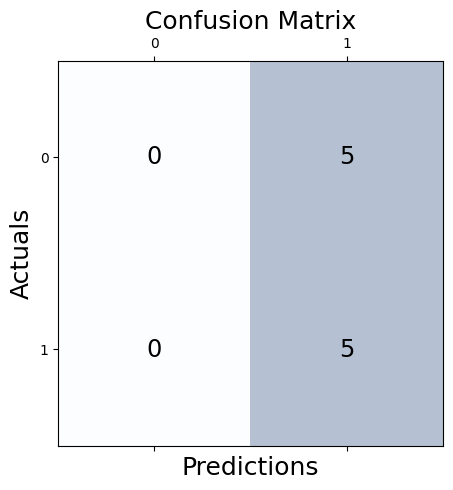

In [115]:
pbmc_conf_matrix = confusion_matrix(y_true = pbmc_metadata['category'].values, y_pred = pbmc_prediction_result)
# Print the confusion matrix using Matplotlib
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(pbmc_conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(pbmc_conf_matrix.shape[0]):
    for j in range(pbmc_conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=pbmc_conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [116]:
# Scores
print('Accuracy: %.3f' % accuracy_score(pbmc_metadata['category'], pbmc_prediction_result))
print('F1 Score (weighted): %.3f' % f1_score(pbmc_metadata['category'], pbmc_prediction_result, average='weighted'))
print('Precision (weighted): %.3f' % precision_score(pbmc_metadata['category'], pbmc_prediction_result, average='weighted'))
print('Recall (weighted): %.3f' % recall_score(pbmc_metadata['category'], pbmc_prediction_result, average='weighted'))

Accuracy: 0.500
F1 Score (weighted): 0.333
Precision (weighted): 0.250
Recall (weighted): 0.500


c:\Users\ngduy\Documents\Project\PMBC_analysis\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


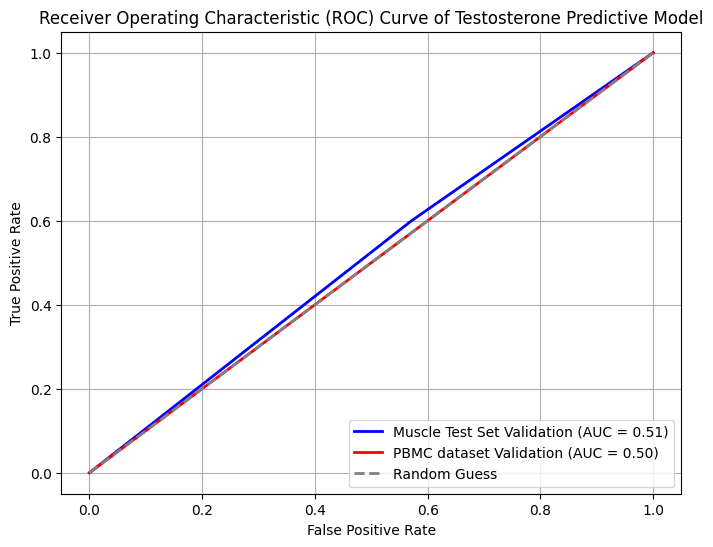

In [117]:
# ROC curve
pbmc_y_true = np.array(pbmc_metadata['category'].values)
pbmc_pred_array = np.array(pbmc_prediction_result)
pbmc_roc = roc_auc_score(pbmc_y_true, pbmc_pred_array)

pbmc_fpr, pbmc_tpr, pbmc_thresholds = roc_curve(pbmc_y_true, pbmc_pred_array)
# plt.figure()
# plt.plot(fpr, tpr, label='Model (Area = %0.2f)' % roc) 
# plt.plot([0, 1], [0, 1],'r--')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver Operating Characteristic')
# plt.legend(loc="lower right")
# plt.show()
# Plotting the ROC curves
plt.figure(figsize=(8, 6))
plt.plot(muscle_fpr, muscle_tpr, color='blue', lw=2, label=f'Muscle Test Set Validation (AUC = {muscle_roc:.2f})')
plt.plot(pbmc_fpr, pbmc_tpr, color='red', lw=2, label=f'PBMC dataset Validation (AUC = {pbmc_roc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2, label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve of Testosterone Predictive Model')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

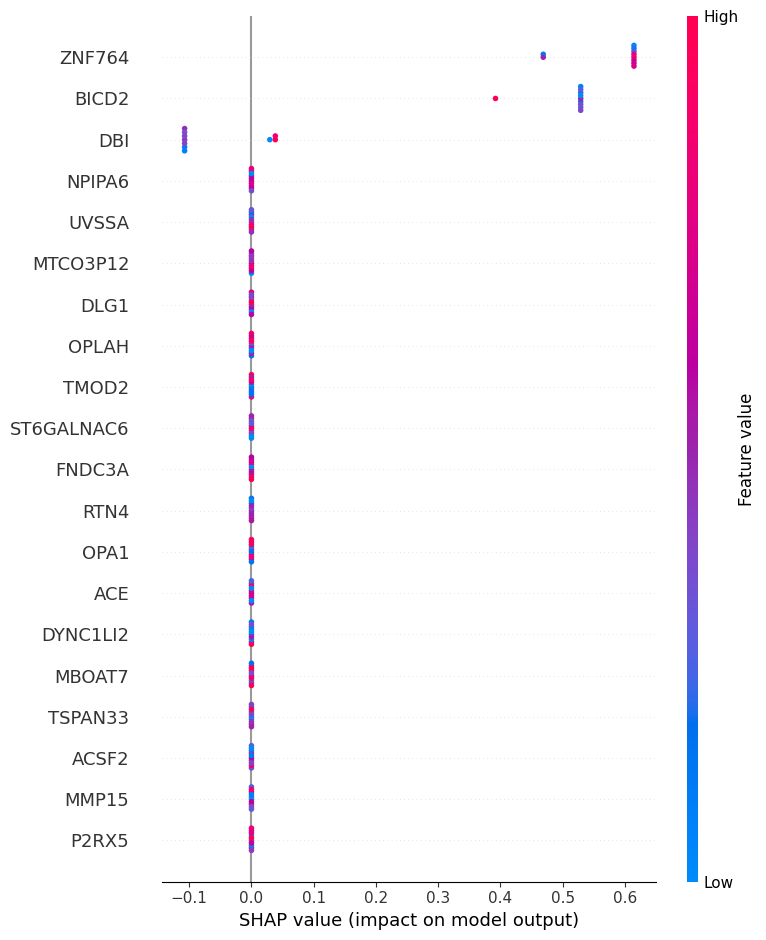

In [118]:
shap.initjs()

# Apply the generated model to the whole dataset and calculate the shap values
pbmc_shap_values = shap.TreeExplainer(model).shap_values(pbmc_data_filtered.values)  
pbmc_explainer = shap.TreeExplainer(model, pbmc_data_filtered.values)
pbmc_expected_value = explainer.expected_value

features = pbmc_data_filtered.columns

# Convert data DF to array
pbmc_data_ = pbmc_data_filtered.to_numpy()

# Run predictions for the whole dataset
pbmc_d_data = xgb.DMatrix(pbmc_data_filtered, label=pbmc_metadata['category'].to_numpy())

preds_data = model.predict(pbmc_d_data)
prediction_data =[]
for i in preds_data:
    if i >=0.5:
        prediction_data.append(1)
    else:
        prediction_data.append(0)

# Print the shap summary plot
shap.summary_plot(pbmc_shap_values, pbmc_data_filtered, feature_names=pbmc_data_filtered.columns) 

In [119]:
# Rank the clinical data by testosterone level, and get the positions of the 5 samples
# with the highest testosterone level and the 5 samples with the lowest 

DAranking = pbmc_metadata[['testosterone']]
DAranking.insert(loc=0, column="rowPosition", value=np.arange(len(DAranking))) # column with row position
DAranking = DAranking.sort_values(by = 'testosterone', ascending = False)         # sort testosterone level in descending order
DAranking.insert(loc=0, column="DAorder", value=np.arange(len(DAranking)))     # column with testosterone level order position
DAranking = DAranking.drop(columns="testosterone")

# Get row positions of top 5
positionlist = DAranking["rowPosition"].tolist()
TopDA = positionlist[:5]
print("TOP 5 DA rows", TopDA)

# Get row positions of bottom 5
positionlist.reverse()
BotDA = positionlist[:5]
print("BOTTOM 5 DA rows", BotDA)

# testosterone level into a series        
DA = metadata[['testosterone']]
DA = DA.to_numpy()


TOP 5 DA rows [9, 8, 7, 6, 5]
BOTTOM 5 DA rows [0, 1, 2, 3, 4]


In [120]:
print(pbmc_y_true.tolist())
print(prediction_data)

[0, 0, 0, 0, 0, 1, 1, 1, 1, 1]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


************************************
Ground Truth Label: 1
Model Prediction:  1 -- Correct
Score: [344]
************************************



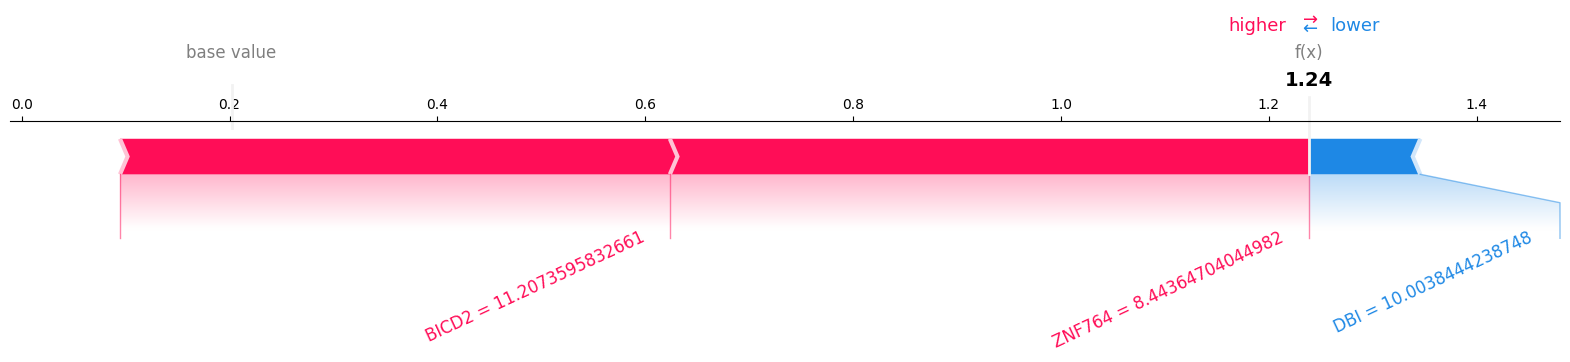

************************************
Ground Truth Label: 1
Model Prediction:  1 -- Correct
Score: [343]
************************************



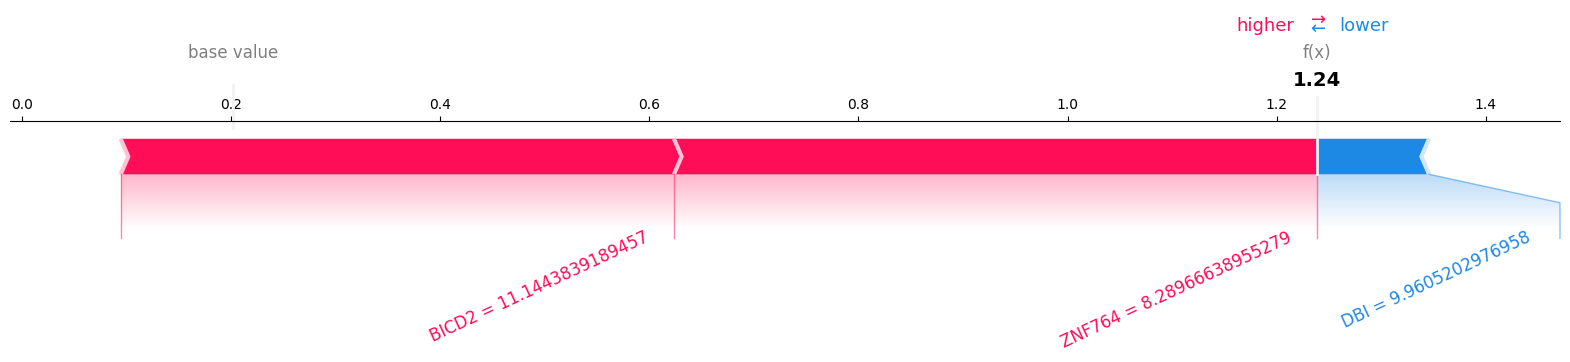

************************************
Ground Truth Label: 1
Model Prediction:  1 -- Correct
Score: [343]
************************************



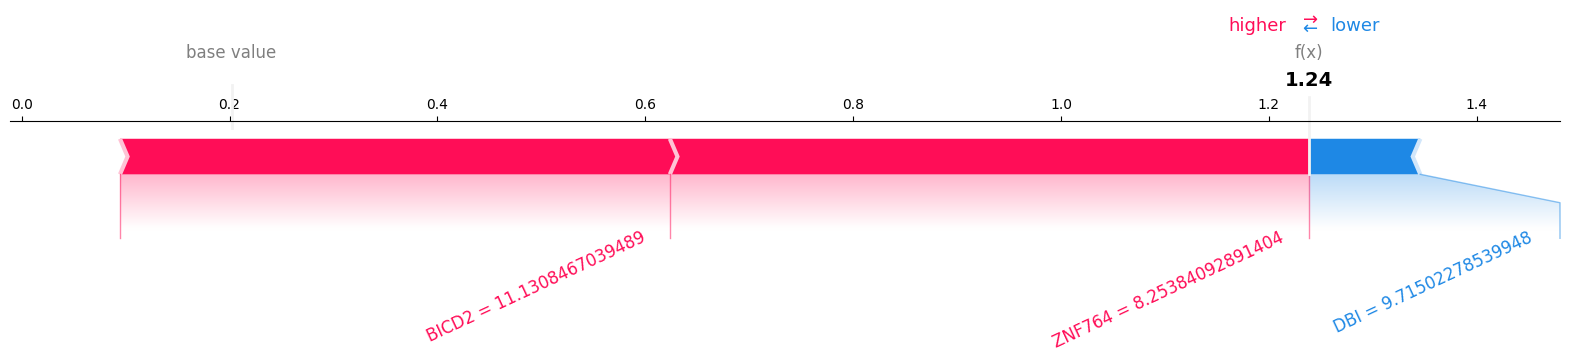

************************************
Ground Truth Label: 1
Model Prediction:  1 -- Correct
Score: [330]
************************************



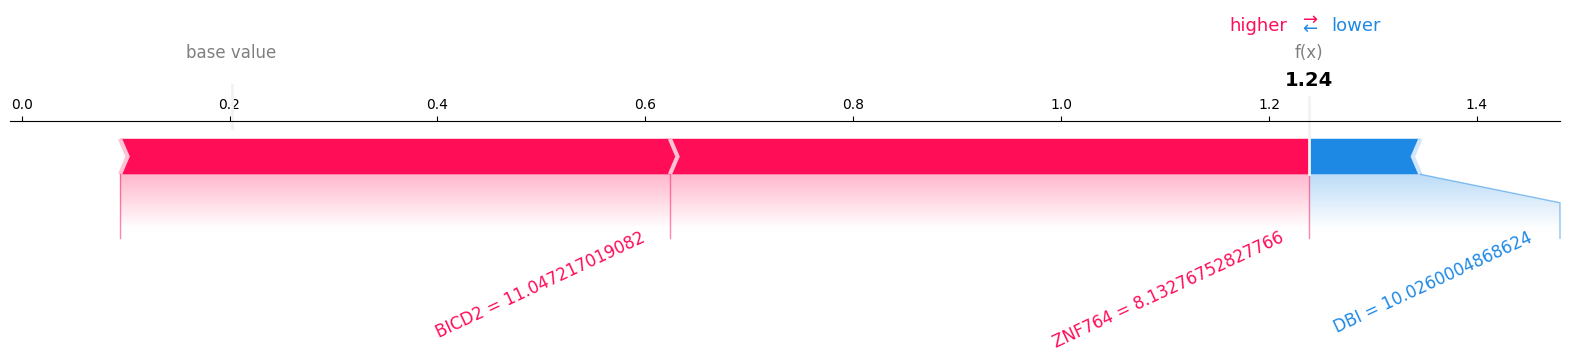

************************************
Ground Truth Label: 1
Model Prediction:  1 -- Correct
Score: [325]
************************************



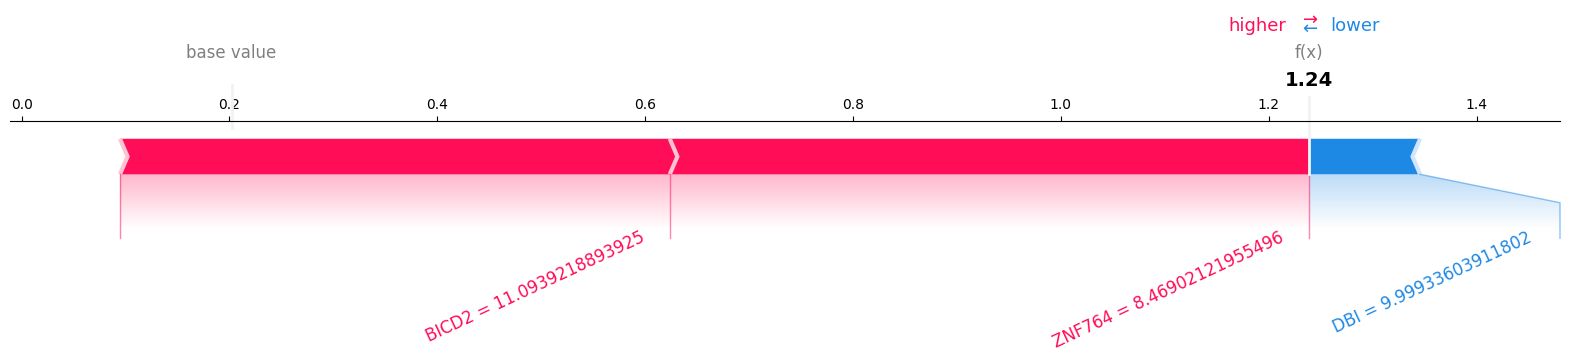

In [121]:
# Force plots for top 5 testosterone level
for i in TopDA:
    shap_accuracy(prediction_data, i, pbmc_y_true, DA)
    shap.force_plot(pbmc_expected_value, pbmc_shap_values[i], pbmc_data_[i], feature_names = features,
                matplotlib = True, plot_cmap="PkYg", text_rotation = 25)

************************************
Ground Truth Label: 0
Model Prediction:  1 -- Incorrect
Score: [85]
************************************



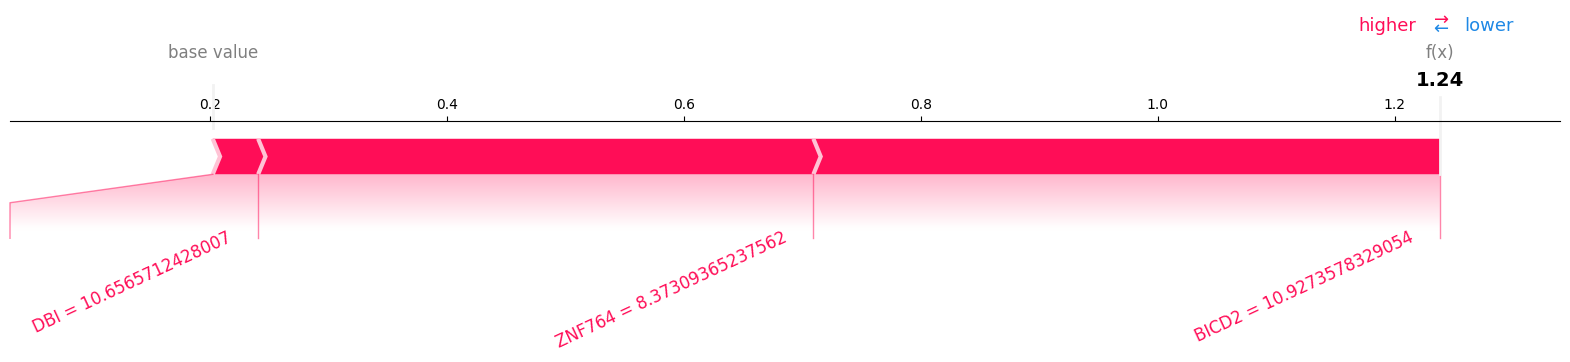

************************************
Ground Truth Label: 0
Model Prediction:  1 -- Incorrect
Score: [144]
************************************



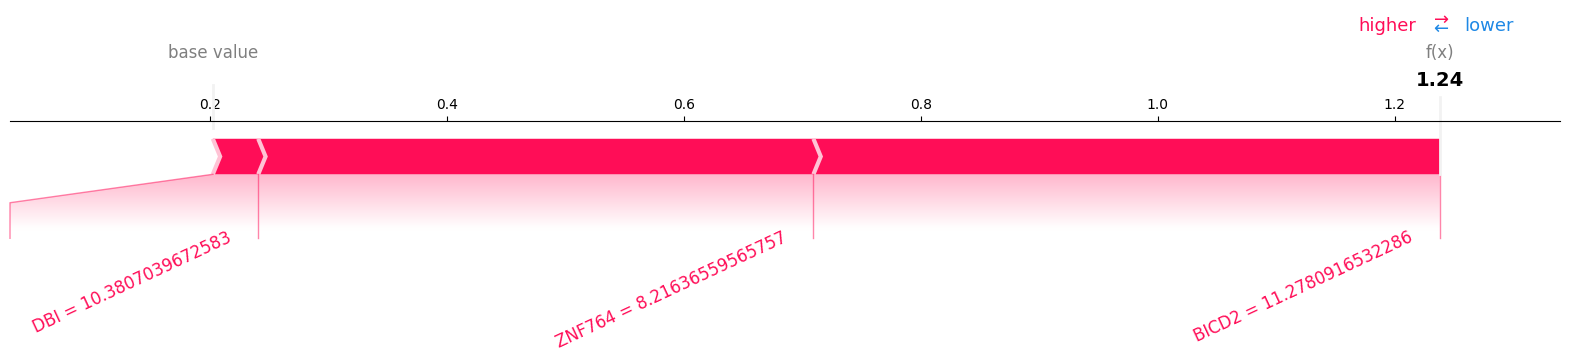

************************************
Ground Truth Label: 0
Model Prediction:  1 -- Incorrect
Score: [275]
************************************



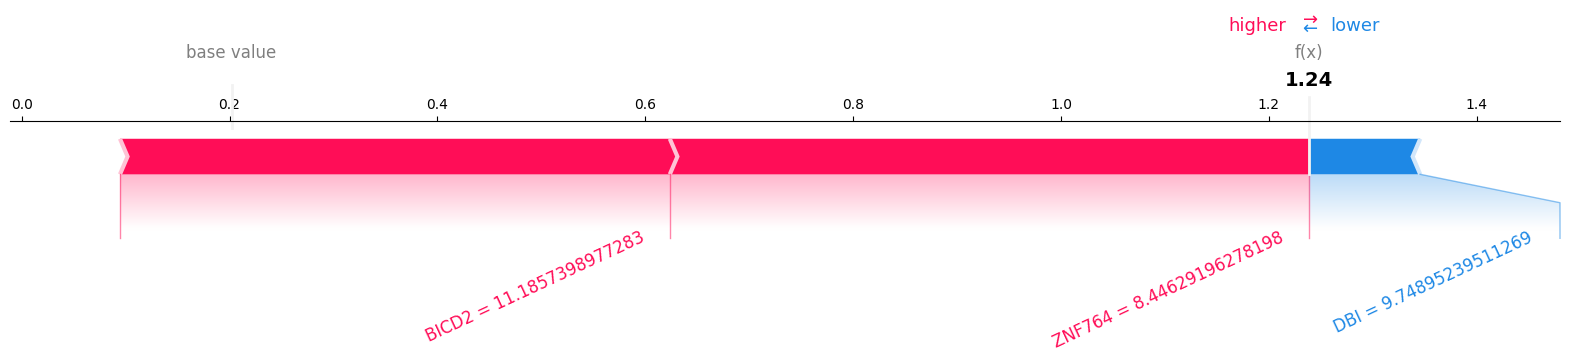

************************************
Ground Truth Label: 0
Model Prediction:  1 -- Incorrect
Score: [309]
************************************



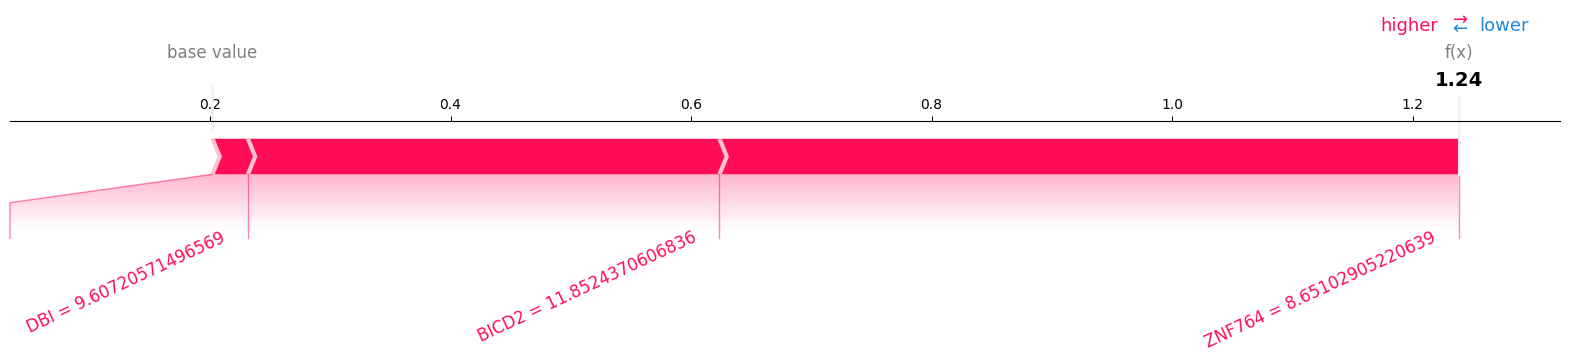

************************************
Ground Truth Label: 0
Model Prediction:  1 -- Incorrect
Score: [324]
************************************



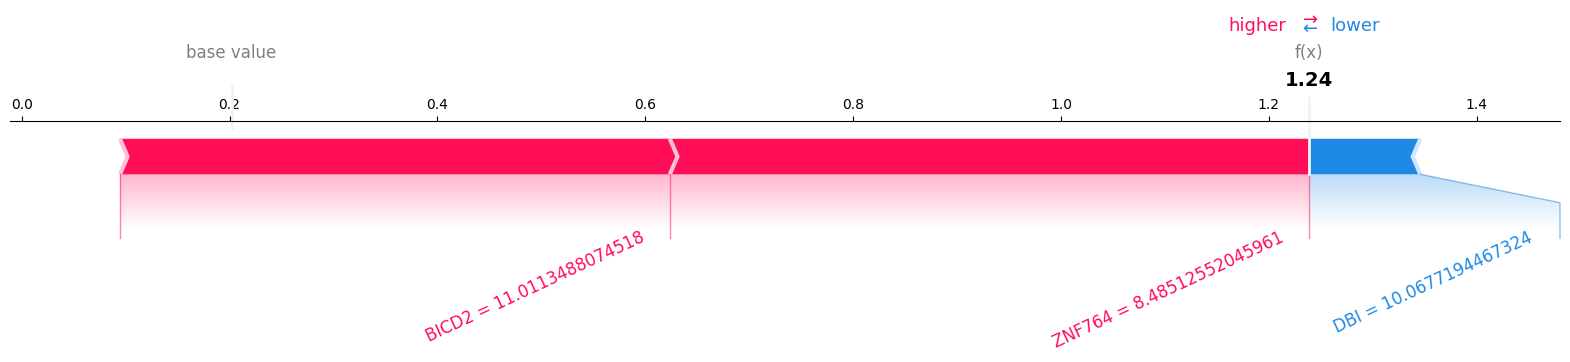

In [122]:
# Force plots for bottom 5 testosterone level
for i in BotDA:
    shap_accuracy(prediction_data, i, pbmc_y_true, DA)
    shap.force_plot(pbmc_expected_value, pbmc_shap_values[i], pbmc_data_[i], feature_names = features,
                matplotlib = True, plot_cmap="PkYg", text_rotation = 25)